In [1]:
import os
import time
import random
import numpy as np
from imutils import paths
import pandas as pd
from tqdm import tqdm
import json
import datetime




import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
import plotly.express as px
import plotly.graph_objects as go


from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, AveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

In [2]:
# Définir le chemin du dataset
train_dir = '../SF-MASK-dataset/train'
test_dir = '../SF-MASK-dataset/test'

# Compter les images dans chaque sous-dossier
train_compliant = len(os.listdir(os.path.join(train_dir, 'compliant')))
train_non_compliant = len(os.listdir(os.path.join(train_dir, 'non-compliant')))
test_compliant = len(os.listdir(os.path.join(test_dir, 'compliant')))
test_non_compliant = len(os.listdir(os.path.join(test_dir, 'non-compliant')))

print(f"Training dataset: Compliant: {train_compliant}, Non-compliant: {train_non_compliant}")
print(f"Test dataset: Compliant: {test_compliant}, Non-compliant: {test_non_compliant}")


Training dataset: Compliant: 21384, Non-compliant: 15772
Test dataset: Compliant: 3622, Non-compliant: 5048


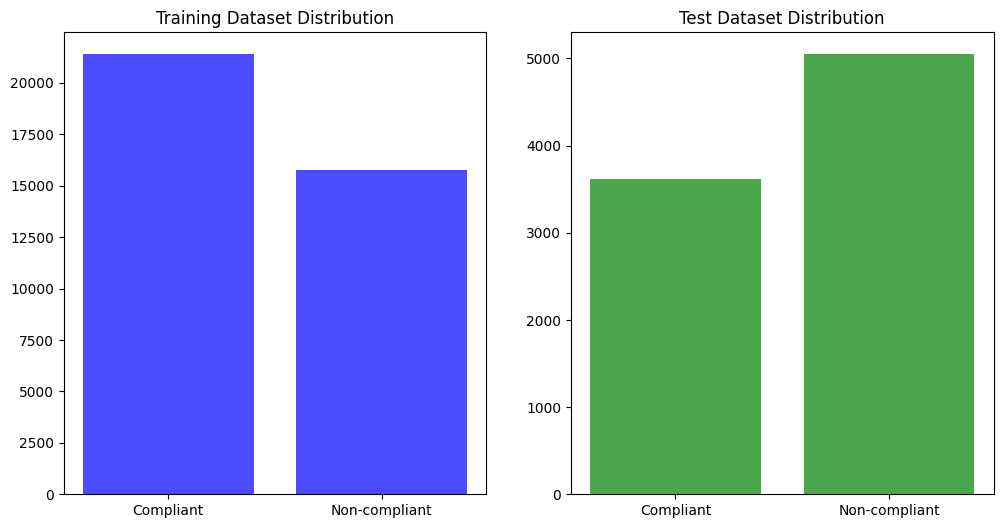

In [3]:
# Distribution des classes dans le dataset
categories = ['Compliant', 'Non-compliant']
train_counts = [train_compliant, train_non_compliant]
test_counts = [test_compliant, test_non_compliant]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(categories, train_counts, color='blue', alpha=0.7)
ax[0].set_title('Training Dataset Distribution')
ax[1].bar(categories, test_counts, color='green', alpha=0.7)
ax[1].set_title('Test Dataset Distribution')

plt.show()


Nous pourrons maintenant choisir une technique de redimensionnement basée sur les tailles les plus courantes, comme :

- Redimensionnement à une taille fixe (ex. 224x224).
- Maintien des proportions avec padding.
- Recadrage au centre.

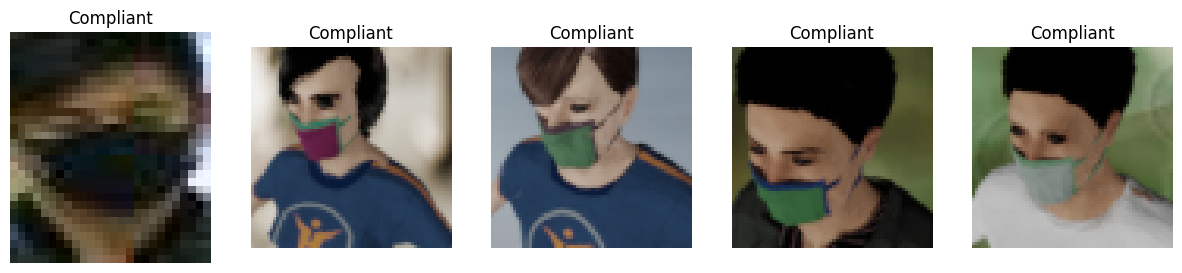

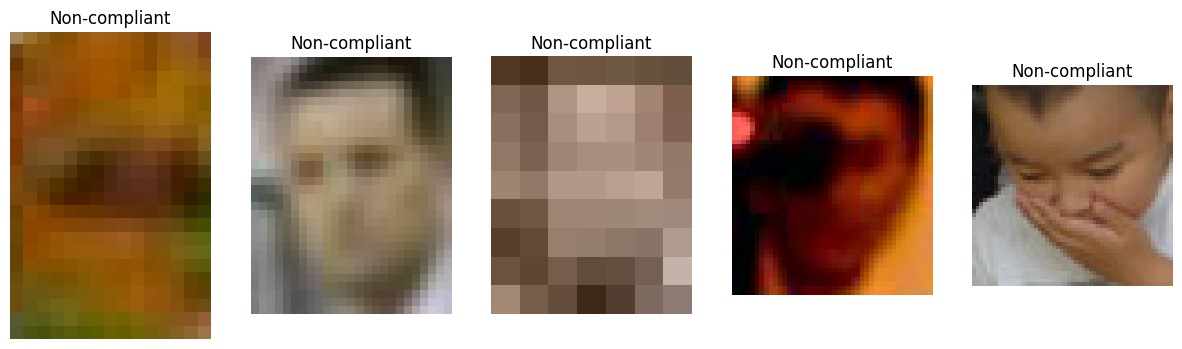

In [4]:
# Fonction pour afficher quelques images d'exemple
def display_images_from_folder(folder, label, num_images=5):
    images = os.listdir(folder)
    random_images = random.sample(images, num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, img_name in enumerate(random_images):
        img_path = os.path.join(folder, img_name)
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(label)
    plt.show()

# Affichage d'exemples de chaque catégorie
display_images_from_folder(os.path.join(train_dir, 'compliant'), 'Compliant')
display_images_from_folder(os.path.join(train_dir, 'non-compliant'), 'Non-compliant')


2. Ajout de padding pour maintenir les proportions
Description :
Agrandit l'image de 64x64 à 224x224 en ajoutant des bandes noires ou blanches autour de l'image.
Préserve le ratio aspect de l'image d'origine.
Avantages :
Maintient les proportions et évite la distorsion.
Idéal pour des modèles qui tolèrent des zones neutres (comme MobileNet).
Inconvénients :
Peut inclure trop d'espace inutile dans l'image.

In [5]:
output_dir_train = "../SF-MASK-dataset-padded/train"
output_dir_test = "../SF-MASK-dataset-padded/test"

In [ ]:
def pad_and_resize(input_dir, output_dir, target_size=(224, 224)):
    os.makedirs(output_dir, exist_ok=True)
    for category in os.listdir(input_dir):
        category_path = os.path.join(input_dir, category)
        output_category_path = os.path.join(output_dir, category)
        os.makedirs(output_category_path, exist_ok=True)
        
        for filename in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            input_path = os.path.join(category_path, filename)
            output_path = os.path.join(output_category_path, filename)
            try:
                with Image.open(input_path) as img:
                    old_size = img.size  # (width, height)
                    ratio = float(target_size[0]) / max(old_size)
                    new_size = tuple([int(x * ratio) for x in old_size])
                    img_resized = img.resize(new_size, Image.Resampling.LANCZOS)  # Correction ici
                    
                    new_img = Image.new("RGB", target_size, (0, 0, 0))  # Black padding
                    new_img.paste(
                        img_resized,
                        ((target_size[0] - new_size[0]) // 2, (target_size[1] - new_size[1]) // 2),
                    )
                    new_img.save(output_path)
            except Exception as e:
                print(f"Erreur avec {input_path}: {e}")


Processing non-compliant: 100%|██████████| 5048/5048 [02:30<00:00, 33.57it/s]


In [ ]:
# # Appliquer le padding sur les dossiers train et test
# pad_and_resize(train_dir, output_dir_train)
# pad_and_resize(test_dir, output_dir_test)

NameError: name 'pad_and_resize' is not defined

# Torch training pipeline

The code enhances the training pipeline, saving model weights, logging metrics, and generating useful plots. Additionally, it includes logging and the saving of metrics in a JSON file for later evaluation.

### Key Features of the Code:
1. **Model Training**:
   - Loads the MobileNetV2 model pretrained on ImageNet.
   - Adjusts the final classification layer to fit the number of classes in your dataset.
   - Saves the model weights after training (`mobilenetv2_trained.pth`).

2. **Metrics Logging**:
   - Saves key metrics such as the training loss, time per epoch, and model accuracy.
   - All the metrics are stored in a `training_metrics.json` file for later analysis.

3. **Plotting**:
   - Uses Plotly to plot the training loss and epoch times. These are displayed interactively in the notebook and saved as an HTML file for later review.

4. **Device Information**:
   - Tracks whether training is done on a GPU or CPU, and logs this in the metrics file.

5. **Saving & Loading the Model**:
   - After training, the model weights are saved to a file, making it easy to load and reuse later.

### Documentation (Markdown)
This script implements a training pipeline for MobileNetV2 on a custom dataset, which includes model training, evaluation, and saving key metrics and plots. The workflow includes:

1. **Data Preparation**: The dataset is loaded and preprocessed, including normalization and splitting for training and testing.
   
2. **Model Setup**: The pretrained MobileNetV2 model is loaded, and its classifier is adapted to fit the number of classes in the dataset.
   
3. **Training Process**: The model is trained for 3 epochs, with the loss and epoch time logged. The model weights are saved after training.

4. **Evaluation**: The trained model is evaluated on the test dataset, and accuracy is reported.

5. **Metrics and Visualization**:
   - Training metrics, including loss, epoch time, and accuracy, are saved to a JSON file.
   - Training progress is visualized using Plotly, with interactive plots saved as HTML.

### Enhancements and Additional Suggestions:
- **Model Fine-Tuning**: You can experiment with fine-tuning more layers of the MobileNetV2 model for improved performance.
- **Learning Rate Scheduling**: Incorporate learning rate schedulers to adjust the learning rate during training for better convergence.
- **Cross-Validation**: Consider using cross-validation for more robust model evaluation.

Let me know if you need further modifications or enhancements!

In [6]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchsummary import summary

In [12]:
!nvidia-smi

Thu Nov 28 15:53:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.03                 Driver Version: 561.03         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8              7W /   35W |      46MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used : {device}")

CUDA is available. Using GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Device used : cuda


In [31]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Loading datasets
train_dataset = datasets.ImageFolder(output_dir_train, transform=transform)
test_dataset = datasets.ImageFolder(output_dir_test, transform=transform)

# Data Splitting for Training Subset
proportion = 0.33  # Modify proportion as needed
subset_size_train = int(len(train_dataset) * proportion)
subset_size_test = int(len(test_dataset) * proportion)

train_subset, _ = random_split(train_dataset, [subset_size_train, len(train_dataset) - subset_size_train])
test_subset, _ = random_split(test_dataset, [subset_size_test, len(test_dataset) - subset_size_test])

# Define the proportion for train/validation split
train_val_proportion = 0.8  # 80% for training, 20% for validation

# Calculate subset sizes
train_size = int(len(train_subset) * train_val_proportion)
val_size = len(train_subset) - train_size
train_subset, val_subset = random_split(train_subset, [train_size, val_size])


# DataLoaders
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)  # No shuffling for validation
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


len(train_subset), len(val_subset), len(test_subset)

(9808, 2453, 2861)

In [32]:
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs, training_time_name):
    training_metrics = []
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        epoch_time = time.time() - epoch_start_time
        avg_loss = total_loss / len(train_loader)

        # Validation metrics
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Store epoch metrics
        epoch_metrics = {
            "epoch": epoch + 1,
            "train_loss": avg_loss,
            "val_loss": avg_val_loss,
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
            "time": epoch_time,
            "learning_rate": optimizer.param_groups[0]["lr"]  # Learning rate
        }

        training_metrics.append(epoch_metrics)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Time: {epoch_time:.2f}s")

    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f}s")

    # Save model weights after training
    model_save_path = f"training/mobilenetv2_trained_{training_time_name}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model weights saved to {model_save_path}")

    return training_metrics, model_save_path



# Evaluate Model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy


In [33]:
# Training the model

print(f"Classes number : {len(train_dataset.classes)}")

# Load Pretrained MobileNetV2
model = models.mobilenet_v2(pretrained=True) # transfert learning
model.classifier[1] = nn.Linear(model.last_channel, len(train_dataset.classes))  # Adjust for number of classes

# Get current date and time
training_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
training_time_name = training_time.replace(" ", "_").replace(":", "-")

# Define hyperparameters

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20


Classes number : 2


c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.



In [34]:
training_metrics, model_save_path = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs, training_time_name)

Epoch 1/20, Train Loss: 0.1896, Train Accuracy: 93.02%, Val Loss: 0.1205, Val Accuracy: 95.60%, Time: 108.75s
Epoch 2/20, Train Loss: 0.1235, Train Accuracy: 95.64%, Val Loss: 0.1168, Val Accuracy: 96.25%, Time: 77.55s
Epoch 3/20, Train Loss: 0.1021, Train Accuracy: 96.25%, Val Loss: 0.0988, Val Accuracy: 95.76%, Time: 77.60s
Epoch 4/20, Train Loss: 0.0923, Train Accuracy: 96.72%, Val Loss: 0.0961, Val Accuracy: 96.25%, Time: 76.86s
Epoch 5/20, Train Loss: 0.0757, Train Accuracy: 97.16%, Val Loss: 0.1638, Val Accuracy: 94.50%, Time: 76.43s
Epoch 6/20, Train Loss: 0.0854, Train Accuracy: 96.89%, Val Loss: 0.0982, Val Accuracy: 96.53%, Time: 76.07s
Epoch 7/20, Train Loss: 0.0702, Train Accuracy: 97.42%, Val Loss: 0.0846, Val Accuracy: 97.06%, Time: 75.64s
Epoch 8/20, Train Loss: 0.0631, Train Accuracy: 97.76%, Val Loss: 0.0950, Val Accuracy: 96.82%, Time: 75.09s
Epoch 9/20, Train Loss: 0.0682, Train Accuracy: 97.69%, Val Loss: 0.1158, Val Accuracy: 95.56%, Time: 75.90s
Epoch 10/20, Train

In [35]:
# Evaluate the model
accuracy = evaluate_model(model, test_loader)

Accuracy: 96.54%


In [36]:
# Extract model architecture as a dictionary
model_layers = {name: str(layer) for name, layer in model.named_modules()}

metrics = {
    "model_name": "MobileNetV2",
    "training_time_total": training_time,
    "dataset_info": {
        "original_train_dataset_size": len(train_dataset),
        "train_subset_size": len(train_subset),
        "validation_subset_size": len(val_subset),
        "test_subset_size": len(test_subset),
    },
    "training_parameters": {
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": optimizer.param_groups[0]["lr"],  # Ensure learning rate is included
    },
    "model_performance": {
        "test accuracy": accuracy,
        "training_metrics": training_metrics,
    },
    "hardware": {
        "device": str(device),
        "model_architecture": model_layers,
    }
}



metrics_file = "training_metrics.json"
try:
    # Load existing data if the file exists
    with open(metrics_file, "r") as f:
        existing_data = json.load(f)
except FileNotFoundError:
    # File does not exist; start with an empty list
    existing_data = []

# Append new metrics
existing_data.append(metrics)

# Write updated list back to file
with open(metrics_file, "w") as f:
    json.dump(existing_data, f, indent=4)

print(f"Metrics saved to {metrics_file}")

Metrics saved to training_metrics.json


In [37]:
# Extract the data for plotting
epochs = [m["epoch"] for m in training_metrics]
train_losses = [m["train_loss"] for m in training_metrics]
val_losses = [m["val_loss"] for m in training_metrics]
train_accuracies = [m["train_accuracy"] for m in training_metrics]
val_accuracies = [m["val_accuracy"] for m in training_metrics]
times = [m["time"] for m in training_metrics]

# Plot Training and Validation Loss
loss_fig = go.Figure()
loss_fig.add_trace(go.Scatter(
    x=epochs,
    y=train_losses,
    mode='lines+markers',
    name='Training Loss'
))
loss_fig.add_trace(go.Scatter(
    x=epochs,
    y=val_losses,
    mode='lines+markers',
    name='Validation Loss'
))
loss_fig.update_layout(title="Loss Across Epochs",
                       xaxis_title="Epoch",
                       yaxis_title="Loss")
# Save the loss figure as an HTML file
loss_fig.write_html("./training/training_metrics_plot/loss_plot.html")
loss_fig.show()

# Plot Training and Validation Accuracy
accuracy_fig = go.Figure()
accuracy_fig.add_trace(go.Scatter(
    x=epochs,
    y=train_accuracies,
    mode='lines+markers',
    name='Training Accuracy'
))
accuracy_fig.add_trace(go.Scatter(
    x=epochs,
    y=val_accuracies,
    mode='lines+markers',
    name='Validation Accuracy'
))
accuracy_fig.update_layout(title="Accuracy Across Epochs",
                           xaxis_title="Epoch",
                           yaxis_title="Accuracy")
# Save the accuracy figure as an HTML file
accuracy_fig.write_html(f"./training/training_metrics_plot/accuracy_plot_{training_time_name}.html")
accuracy_fig.show()

# Plot Training Time per Epoch
time_fig = go.Figure()
time_fig.add_trace(go.Scatter(
    x=epochs,
    y=times,
    name='Training Time'
))
time_fig.update_layout(title="Training Time per Epoch",
                       xaxis_title="Epoch",
                       yaxis_title="Time (seconds)")
# Save the time figure as an HTML file
time_fig.write_html(f"training/training_metrics_plot/time_plot_{training_time_name}.html")
time_fig.show()



## Prediction by hand 

C:\Users\Sinbad\AppData\Local\Temp\ipykernel_11772\1884032890.py:32: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



La prédiction pour l'image est : compliant


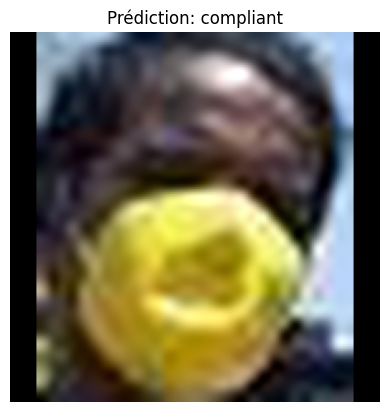

In [35]:
# Function to randomly select an image from the test directory
def get_random_image_from_test_dir(test_dir):
    # Collect all image paths from subdirectories
    image_paths = []
    for root, _, files in os.walk(test_dir):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg')):  # Supported image formats
                image_paths.append(os.path.join(root, file))
    # Randomly select one image
    return random.choice(image_paths)

# Define the function for prediction
def predict_image(image_path, model, transform, classes):
    # Load the image
    image = Image.open(image_path).convert('RGB')
    
    # Apply the transformations
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Pass the image through the model
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        input_tensor = input_tensor.to(device)
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
    
    # Get the predicted class
    predicted_class = classes[predicted.item()]
    return predicted_class, image

# Load the saved model weights
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)

# Path to the image to be tested
# image_path = "../SF-MASK-dataset-padded/test/non-compliant/FMD_maksssksksss38.png"

# Path to the test directory
test_dir = "../SF-MASK-dataset-padded/test"

# Randomly select an image from the test set
image_path = get_random_image_from_test_dir(test_dir)

# Classes du dataset
classes = train_dataset.classes

# Predict the class of the image
predicted_class, image = predict_image(image_path, model, transform, classes)
print(f"La prédiction pour l'image est : {predicted_class}")

# Display the image with its prediction
plt.imshow(image)
plt.title(f"Prédiction: {predicted_class}")
plt.axis("off")
plt.show()


# First training notebook

In [25]:
# Charger les images et les étiquettes
imagePaths = list(paths.list_images(train_dir))  # Path to the train directory
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]  # Extract 'compliant' or 'non-compliant'
    image = load_img(imagePath, target_size=(64, 64))  # Redimensionner à 224x224
    image = img_to_array(image)
    image = preprocess_input(image)  # Prétraitement pour MobileNetV2
    
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

# Convertir les labels en format one-hot
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Diviser en train/test
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)


In [21]:
# Charger MobileNetV2
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(64, 64, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)  # Sortie pour 2 classes

model = Model(inputs=baseModel.input, outputs=headModel)

# Gel des couches de MobileNetV2
for layer in baseModel.layers:
    layer.trainable = False

# Compilation du modèle
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


C:\Users\Sinbad\AppData\Local\Temp\ipykernel_19400\3316388236.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(64, 64, 3)))


In [22]:
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=EPOCHS, batch_size=BS)


Epoch 1/20


c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_318']
Received: inputs=Tensor(shape=(None, 64, 64, 3))
  warnings.warn(msg)


ValueError: Exception encountered when calling AveragePooling2D.call().

[1mNegative dimension size caused by subtracting 7 from 2 for '{{node functional_2_1/average_pooling2d_2_1/AvgPool}} = AvgPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 7, 7, 1], padding="VALID", strides=[1, 7, 7, 1]](functional_2_1/out_relu_1/Relu6)' with input shapes: [?,2,2,1280].[0m

Arguments received by AveragePooling2D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 1280), dtype=float32)